Loaded real objects: 1508
After cuts: 20


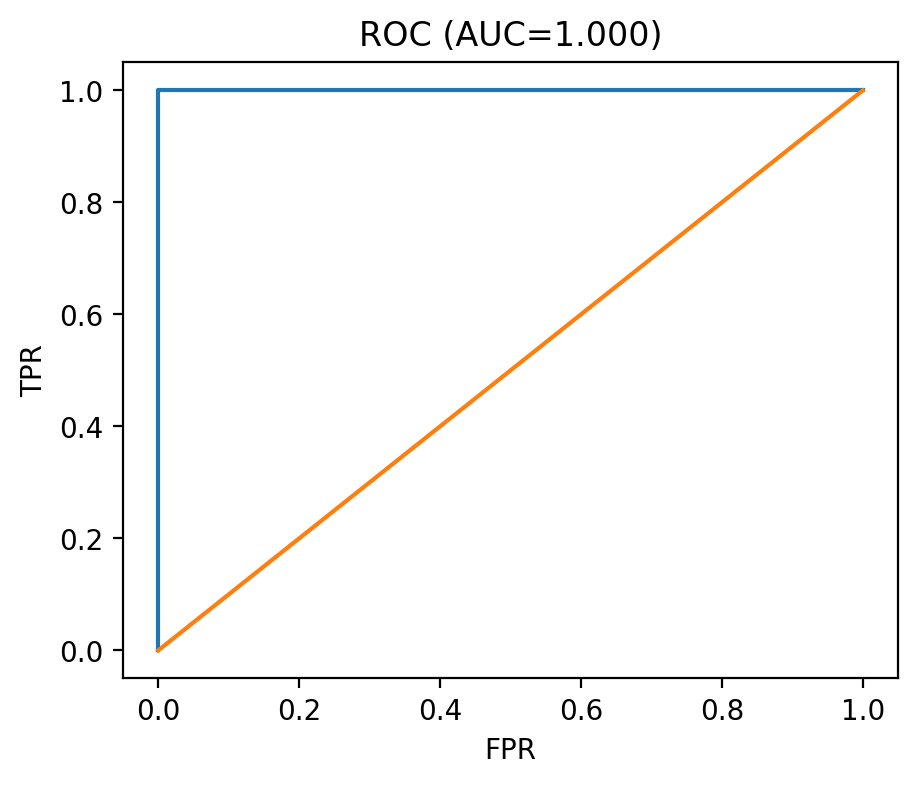

Trained backend: sklearn_logreg
Synthetic test AUC: 1.0
P(PlanetX-like imprint | real catalog) = 2.1035670568949917e-79


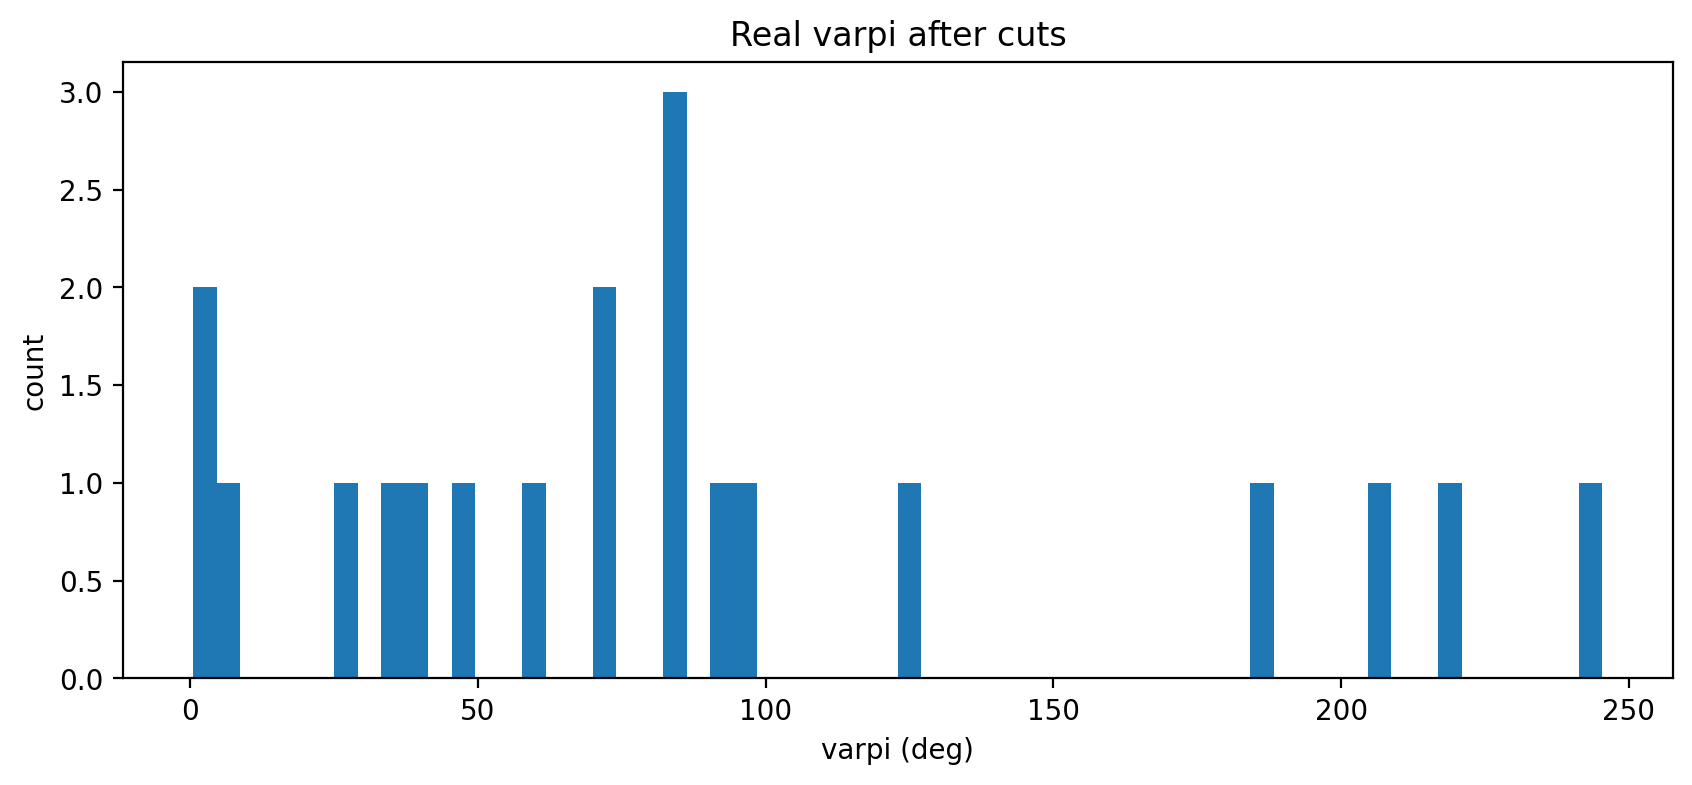

In [3]:
import os, re, math
import numpy as np
import matplotlib.pyplot as plt

def _floats_from_line(line):
    nums = re.findall(r"[+-]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][+-]?\d+)?", line)
    return [float(x) for x in nums]

def load_mpc_distant(path, max_lines=None):
    """
    MPCORB-like: floats contain ... M, omega, Omega, inc, e, n, a ...
    Indices:          4    5      6     7   8      10
    """
    a=[]; e=[]; inc=[]; Om=[]; om=[]; M=[]
    raw = 0
    with open(path, "r", errors="ignore") as f:
        for line in f:
            raw += 1
            if max_lines is not None and raw > max_lines:
                break
            nums = _floats_from_line(line)
            if len(nums) < 11:
                continue
            MM  = nums[4]
            ww  = nums[5]
            OO  = nums[6]
            ii  = nums[7]
            ee  = nums[8]
            aa  = nums[10]
            if not (aa > 0 and 0 <= ee < 1.5 and 0 <= ii <= 180 and 0 <= OO <= 360 and 0 <= ww <= 360 and 0 <= MM <= 360):
                continue
            a.append(aa); e.append(ee); inc.append(ii); Om.append(OO); om.append(ww); M.append(MM)
    if len(a) == 0:
        raise ValueError(f"No valid rows parsed. PATH={path!r}. Try: print(os.getcwd()); print(os.listdir('.'))")
    return {
        "a": np.array(a, float),
        "e": np.array(e, float),
        "inc": np.array(inc, float),
        "Omega": np.array(Om, float),
        "omega": np.array(om, float),
        "M": np.array(M, float),
        "used_rows": len(a),
        "raw_lines": raw
    }

def ang_wrap_deg(x):
    return np.mod(x, 360.0)

def circ_mean_deg(theta_deg):
    th = np.deg2rad(theta_deg)
    return ang_wrap_deg(np.rad2deg(np.arctan2(np.mean(np.sin(th)), np.mean(np.cos(th)))))

def circ_R(theta_deg):
    th = np.deg2rad(theta_deg)
    c = np.mean(np.cos(th))
    s = np.mean(np.sin(th))
    return float(np.sqrt(c*c + s*s))

def circ_std_deg(theta_deg):
    R = np.clip(circ_R(theta_deg), 1e-12, 1.0)
    return float(np.rad2deg(np.sqrt(-2.0*np.log(R))))

def rayleigh_z(theta_deg):
    
    n = len(theta_deg)
    R = circ_R(theta_deg)
    return float(n * (R**2))

def compute_varpi_deg(data):
    return ang_wrap_deg(data["Omega"] + data["omega"])

def resonance_closeness_score(a):
    """
    Malhotra-style proxy:
    For each object, compare period ratio to a few small-integer ratios relative to median.
    P ~ a^(3/2), so ratio in periods is (a_i/a_ref)^(3/2).
    Score is high if many objects sit near low-order ratios.
    """
    a = np.asarray(a, float)
    a_ref = np.median(a)
    Pr = (a / a_ref)**1.5

    ratios = []
    for p in range(1, 6):
        for q in range(1, 6):
            ratios.append(p/q)
    ratios = np.array(ratios, float)

    logPr = np.log(Pr)
    logr = np.log(ratios[None, :])
    d = np.min(np.abs(logPr[:, None] - logr), axis=1)

    tau = 0.02  
    score = float(np.mean(np.exp(-(d/tau)**2)))

    frac_close = float(np.mean(d < 0.01))
    return score, frac_close

def catalog_features(a, e, inc, varpi, Omega):
    a = np.asarray(a); e = np.asarray(e); inc = np.asarray(inc)
    varpi = np.asarray(varpi); Omega = np.asarray(Omega)

    q = a*(1-e)

    R_varpi = circ_R(varpi)
    R_Om = circ_R(Omega)

    thv = np.deg2rad(varpi)
    thO = np.deg2rad(Omega)
    emb = np.vstack([np.cos(thv), np.sin(thv), np.cos(thO), np.sin(thO)]).T
    C = np.corrcoef(emb, rowvar=False)

    c1 = float(abs(C[0,2])); c2 = float(abs(C[1,3])); c3 = float(abs(C[0,3])); c4 = float(abs(C[1,2]))

    res_score, res_frac = resonance_closeness_score(a)

    feats = np.array([
        len(a),
        float(np.mean(a)), float(np.std(a)),
        float(np.mean(q)), float(np.std(q)),
        float(np.mean(inc)), float(np.std(inc)),
        float(np.mean(e)), float(np.std(e)),
        R_varpi, circ_std_deg(varpi), rayleigh_z(varpi),
        R_Om, circ_std_deg(Omega), rayleigh_z(Omega),
        res_score, res_frac,
        c1, c2, c3, c4
    ], float)
    return feats


def selection_accept_prob(a, e, inc):
    
    q = a*(1-e)
    q0 = 45.0   
    i0 = 15.0   
    p = np.exp(-(q/q0)) * np.exp(-(inc/i0))
    
    return np.clip(p / (np.max(p) + 1e-12), 0, 1)

def gen_underlying_population(N):
    
    a = np.random.lognormal(mean=np.log(150), sigma=0.6, size=N)  
    a = np.clip(a, 30, 2000)
    e = np.random.beta(2.0, 5.0, size=N) * 0.9
    inc = np.random.rayleigh(scale=10.0, size=N)  
    inc = np.clip(inc, 0, 60)

    Omega = np.random.uniform(0, 360, size=N)
    omega = np.random.uniform(0, 360, size=N)
    M = np.random.uniform(0, 360, size=N)
    return a, e, inc, Omega, omega, M

def imprint_planetx(a, e, inc, Omega, omega, strength=0.0):
    """
    strength in [0,1]:
      0.0 = null (no imprint)
      1.0 = strong Planet-X-like imprint
    Implements two controlled effects:
      (A) apsidal clustering: varpi concentrated with sigma that increases as strength decreases
      (B) resonance nudging: a nudged toward low-order ratios with step proportional to strength
    """
    a = a.copy()
    Omega2 = Omega.copy()

    N = len(a)

    
    sigma = 15.0 + (1.0 - strength) * 165.0
    center = np.random.uniform(0, 360)

   
    varpi = ang_wrap_deg(np.random.normal(center, sigma, size=N))


    omega2 = ang_wrap_deg(varpi - Omega2)

    
    step = 0.20 * strength

    if step > 0:
        a_ref = np.median(a)
        ratios = []
        for p in range(1, 6):
            for q in range(1, 6):
                ratios.append(p / q)
        ratios = np.array(ratios, float)

        pick = np.random.randint(0, len(ratios), size=N)
        target_Pr = ratios[pick]
        target_a = a_ref * (target_Pr ** (2/3))

        a = np.clip(a*(1-step) + target_a*step, 30, 2000)

    return a, e, inc, Omega2, omega2

def gen_catalog(label, n_obs=300, strength=1.0):
    """
    label 0: null (strength ignored)
    label 1: Planet-X-like (uses 'strength')
    """
    N0 = max(3000, n_obs*20)
    a,e,inc,Omega,omega,M = gen_underlying_population(N0)

    if label == 1:
        a,e,inc,Omega,omega = imprint_planetx(a,e,inc,Omega,omega, strength=strength)

    p = selection_accept_prob(a,e,inc)
    keep = np.random.rand(len(a)) < p

    a2,e2,inc2,Omega2,omega2 = a[keep], e[keep], inc[keep], Omega[keep], omega[keep]

    if len(a2) < n_obs:
        idx = np.argsort(-p)[:n_obs]
        a2,e2,inc2,Omega2,omega2 = a[idx], e[idx], inc[idx], Omega[idx], omega[idx]

    if len(a2) > n_obs:
        idx = np.random.choice(len(a2), n_obs, replace=False)
        a2,e2,inc2,Omega2,omega2 = a2[idx], e2[idx], inc2[idx], Omega2[idx], omega2[idx]

    varpi = ang_wrap_deg(Omega2 + omega2)
    return a2,e2,inc2,varpi,Omega2


def build_dataset(n_catalogs=2000, n_obs=300, strength=1.0, seed=0):
    np.random.seed(seed)
    X = []
    y = []
    for k in range(n_catalogs):
        label = 0 if (k < n_catalogs//2) else 1
        a,e,inc,varpi,Omega = gen_catalog(label, n_obs=n_obs, strength=strength)
        X.append(catalog_features(a,e,inc,varpi,Omega))
        y.append(label)
    X = np.vstack(X)
    y = np.array(y, int)
    perm = np.random.permutation(len(y))
    return X[perm], y[perm]

def train_and_eval(X, y, seed=0):
    np.random.seed(seed)
    n = len(y)
    idx = np.random.permutation(n)
    split = int(0.8*n)
    tr, te = idx[:split], idx[split:]
    Xtr, ytr = X[tr], y[tr]
    Xte, yte = X[te], y[te]

    mu = Xtr.mean(axis=0)
    sd = Xtr.std(axis=0) + 1e-12
    Xtrz = (Xtr - mu)/sd
    Xtez = (Xte - mu)/sd

    try:
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import roc_auc_score, roc_curve

        clf = LogisticRegression(max_iter=5000)
        clf.fit(Xtrz, ytr)
        p = clf.predict_proba(Xtez)[:,1]
        auc = roc_auc_score(yte, p)

        fpr, tpr, _ = roc_curve(yte, p)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1])
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC (AUC={auc:.3f})")
        plt.show()

        return {"model": clf, "mu": mu, "sd": sd, "auc": auc, "backend": "sklearn_logreg"}

    except Exception as ex:
        
        W = np.zeros(Xtrz.shape[1])
        b = 0.0
        lr = 0.1
        for it in range(4000):
            z = Xtrz @ W + b
            p = 1/(1+np.exp(-z))
            
            gW = (Xtrz.T @ (p - ytr))/len(ytr)
            gb = float(np.mean(p - ytr))
            W -= lr*gW
            b -= lr*gb

        zt = Xtez @ W + b
        pt = 1/(1+np.exp(-zt))
     
        order = np.argsort(pt)
        ranks = np.empty_like(order)
        ranks[order] = np.arange(len(pt))
        pos = ranks[yte==1]
        neg = ranks[yte==0]
        auc = (pos[:,None] > neg[None,:]).mean()

        return {"model": (W,b), "mu": mu, "sd": sd, "auc": float(auc), "backend": "numpy_logreg"}

def predict_prob(trained, featvec):
    xz = (featvec - trained["mu"]) / trained["sd"]
    if trained["backend"].startswith("sklearn"):
        return float(trained["model"].predict_proba(xz[None,:])[:,1][0])
    W,b = trained["model"]
    z = float(xz @ W + b)
    return float(1/(1+np.exp(-z)))


PATH = "distant_extended.dat"
if not os.path.exists(PATH):
    print("File not found in current directory.")
    print("cwd:", os.getcwd())
    print("files:", os.listdir("."))
    raise FileNotFoundError(PATH)

real = load_mpc_distant(PATH)
print("Loaded real objects:", real["used_rows"])


a = real["a"]; e = real["e"]; inc = real["inc"]; Omega = real["Omega"]
varpi = compute_varpi_deg(real)
q = a*(1-e)
mask = (a > 150) & (q > 30)   
aR,eR,incR,varpiR,OmegaR = a[mask], e[mask], inc[mask], varpi[mask], Omega[mask]
print("After cuts:", len(aR))

n_obs = len(aR)  
X, y = build_dataset(n_catalogs=2000, n_obs=n_obs, seed=0)

trained = train_and_eval(X, y, seed=0)
print("Trained backend:", trained["backend"])
print("Synthetic test AUC:", trained["auc"])

feat_real = catalog_features(aR, eR, incR, varpiR, OmegaR)
p_planetx = predict_prob(trained, feat_real)
print("P(PlanetX-like imprint, real catalog) =", p_planetx)

plt.figure(figsize=(10,4))
plt.hist(varpiR, bins=60)
plt.xlabel("varpi (deg)")
plt.ylabel("count")
plt.title("Real varpi after cuts")
plt.show()


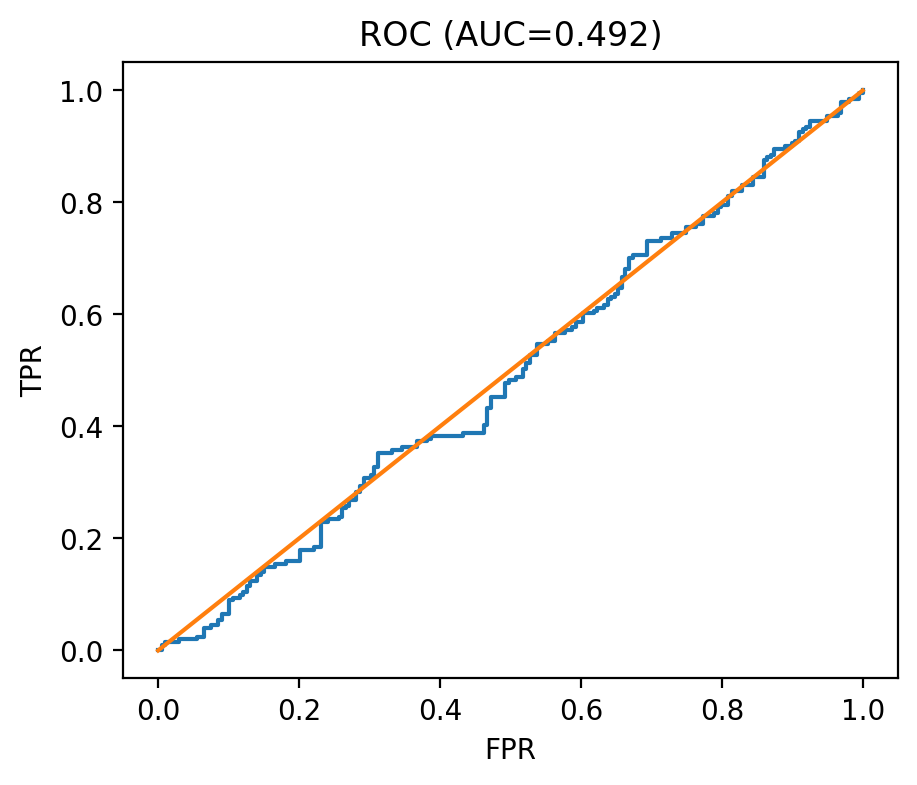

strength=0.00  AUC=0.492  P(real)= 1.0000


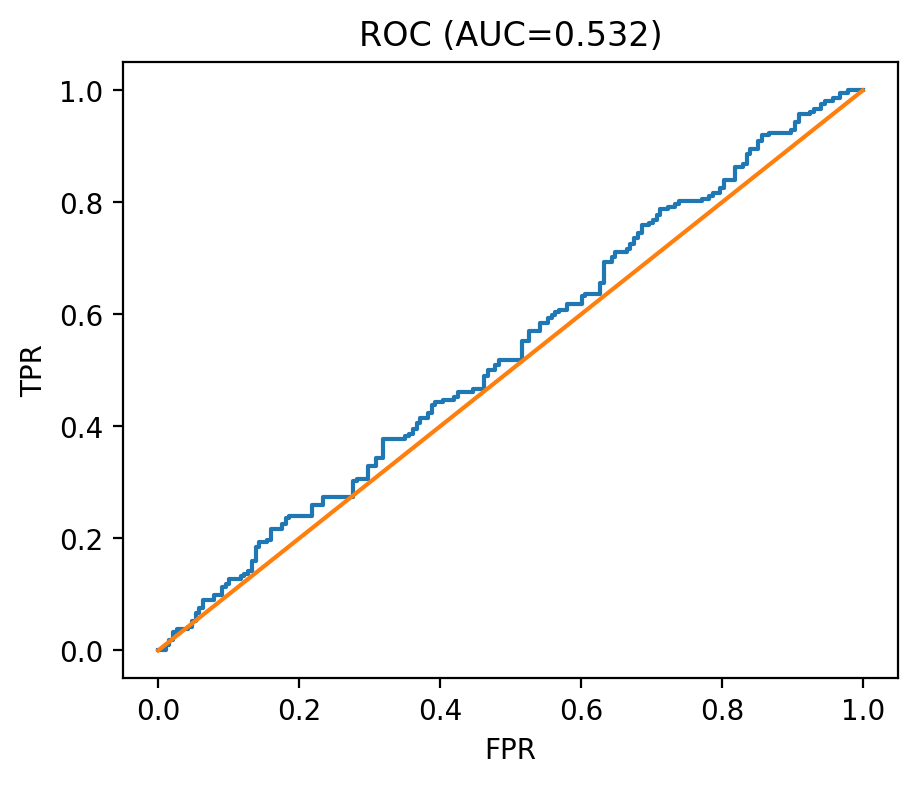

strength=0.10  AUC=0.532  P(real)= 0.0000


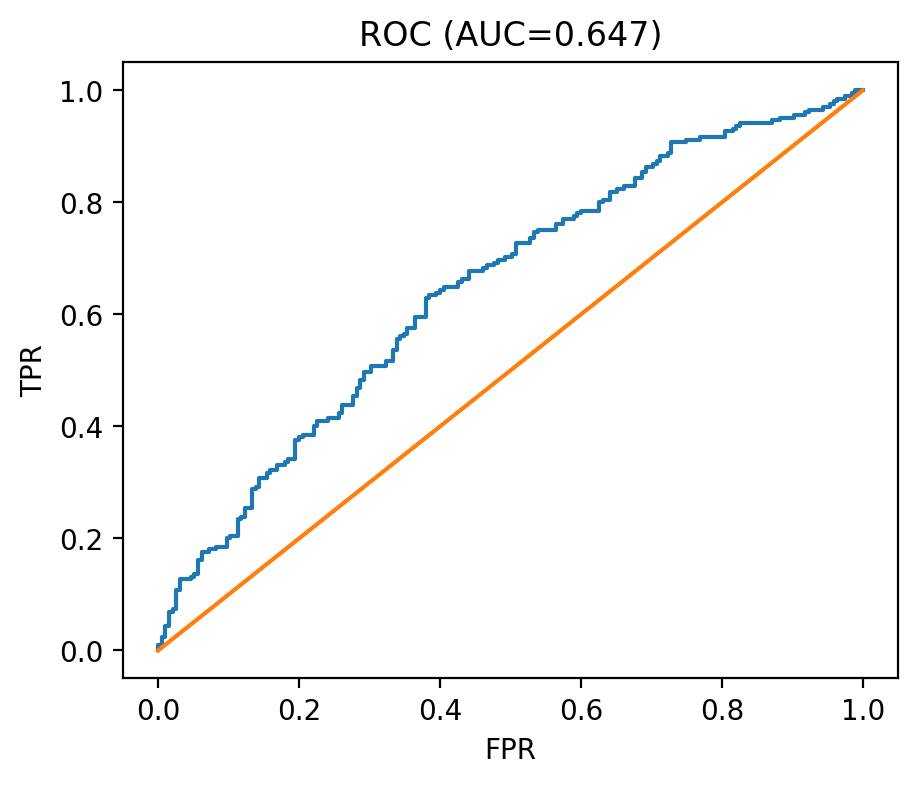

strength=0.20  AUC=0.647  P(real)= 0.0000


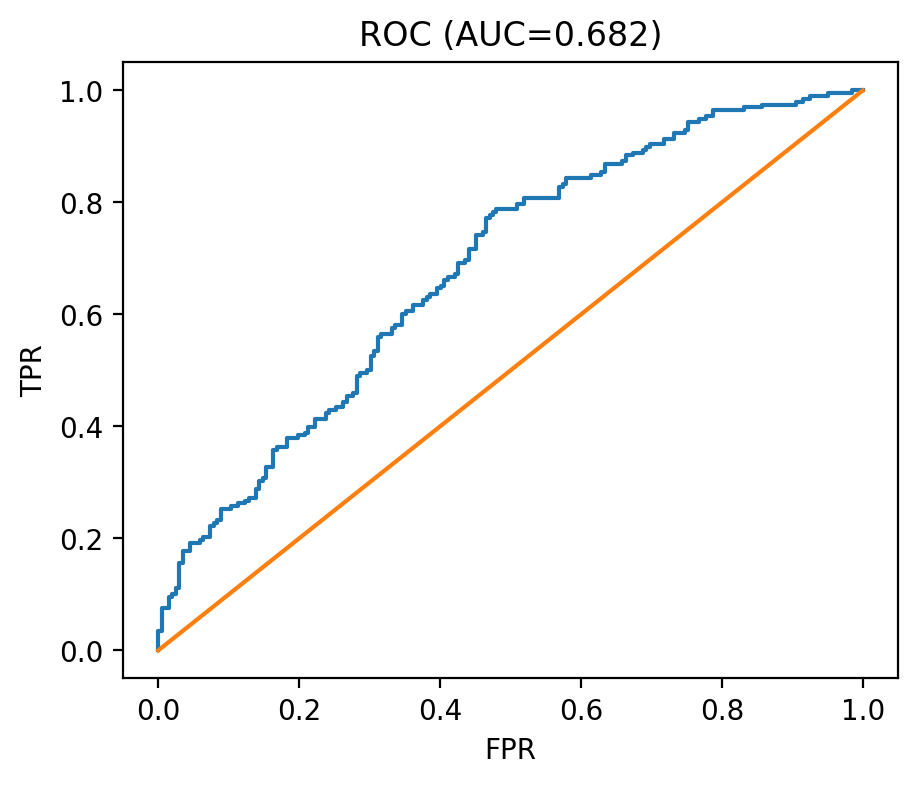

strength=0.30  AUC=0.682  P(real)= 0.0000


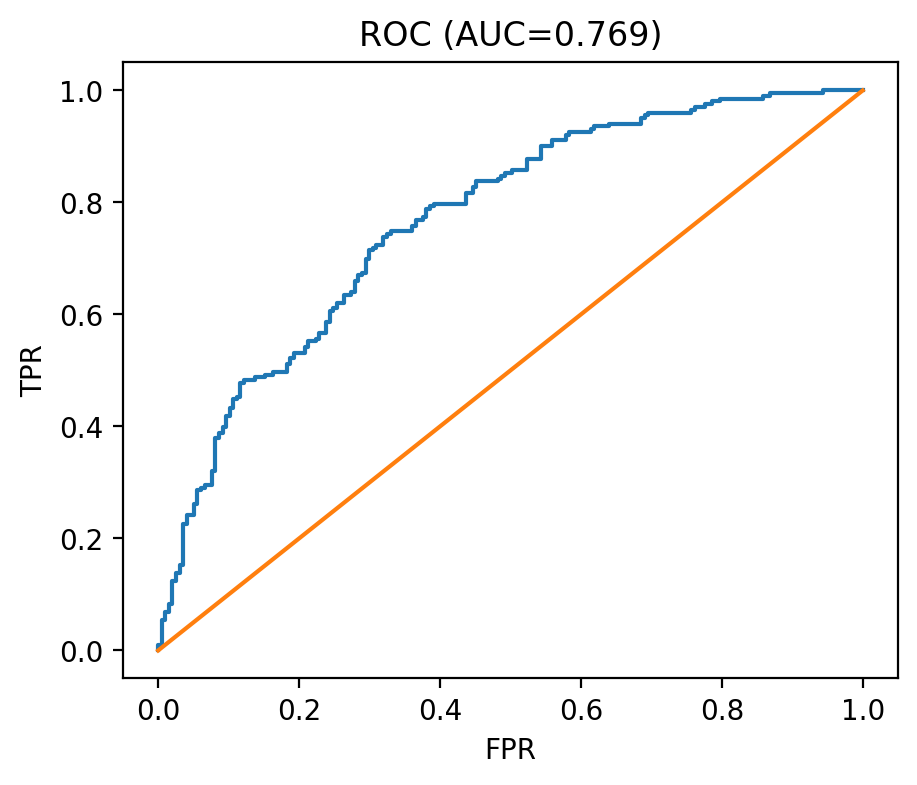

strength=0.40  AUC=0.769  P(real)= 0.0000


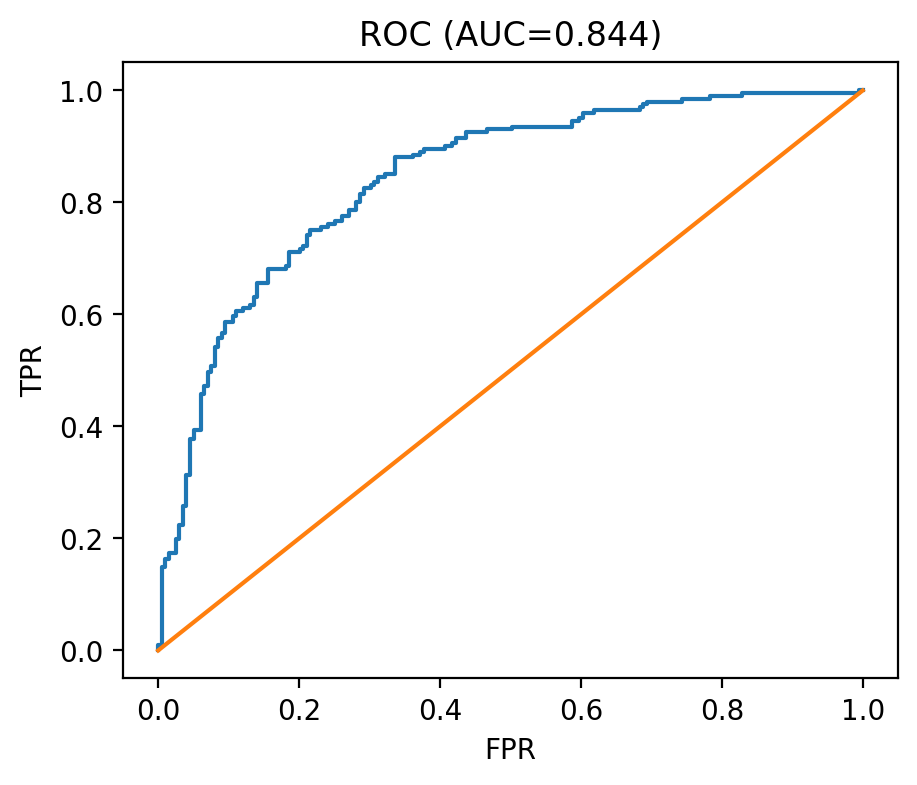

strength=0.50  AUC=0.844  P(real)= 0.0000


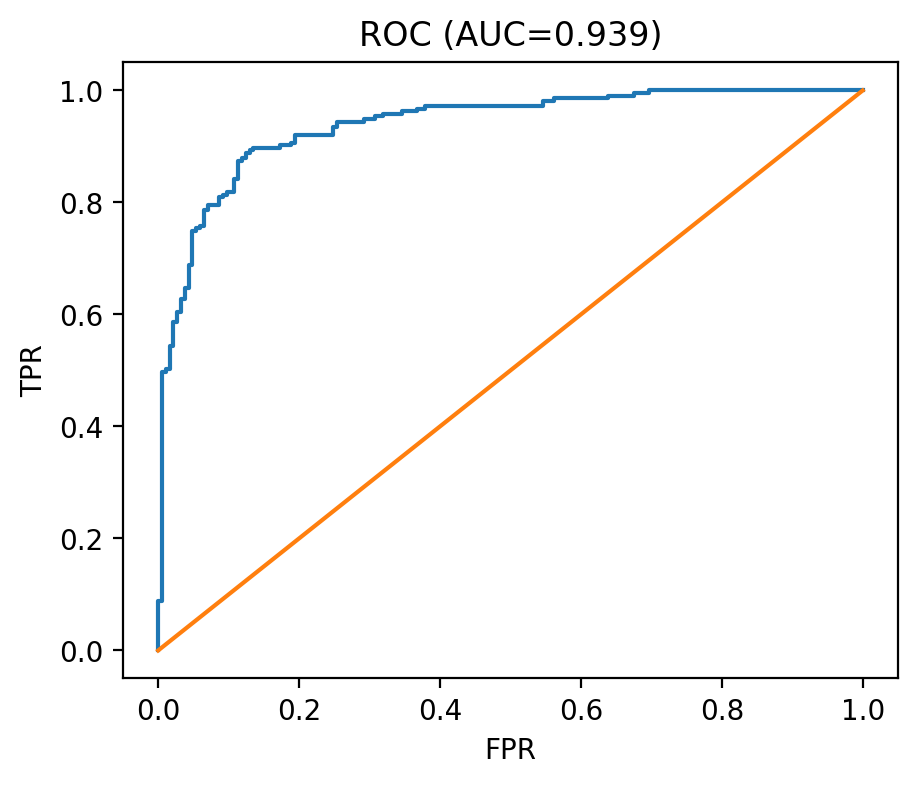

strength=0.60  AUC=0.939  P(real)= 0.0000


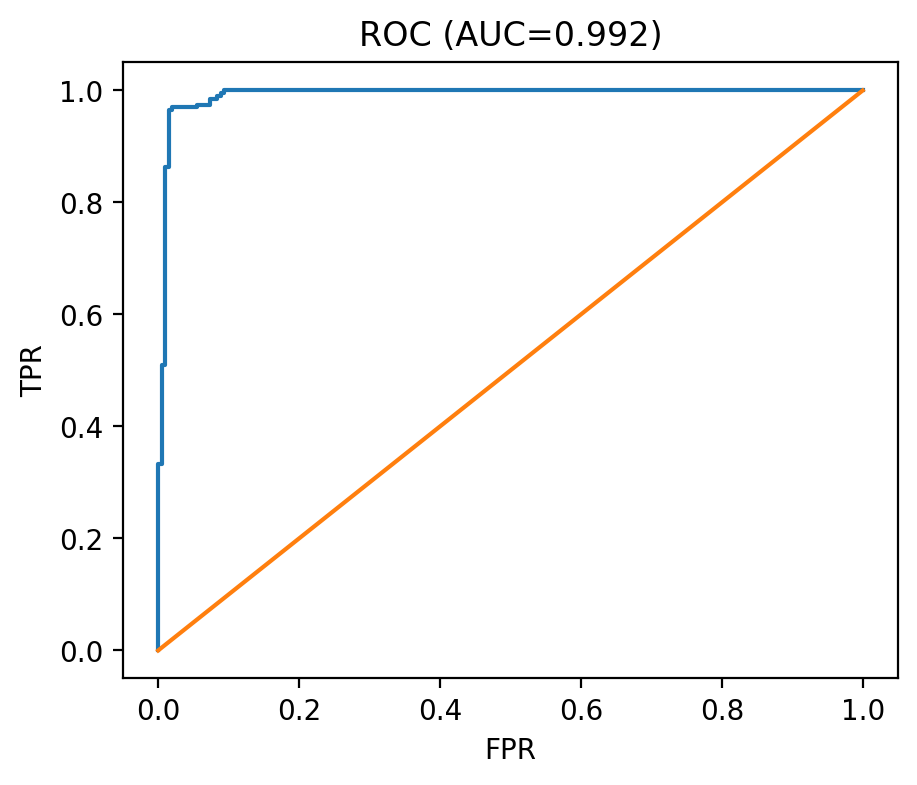

strength=0.70  AUC=0.992  P(real)= 0.0000


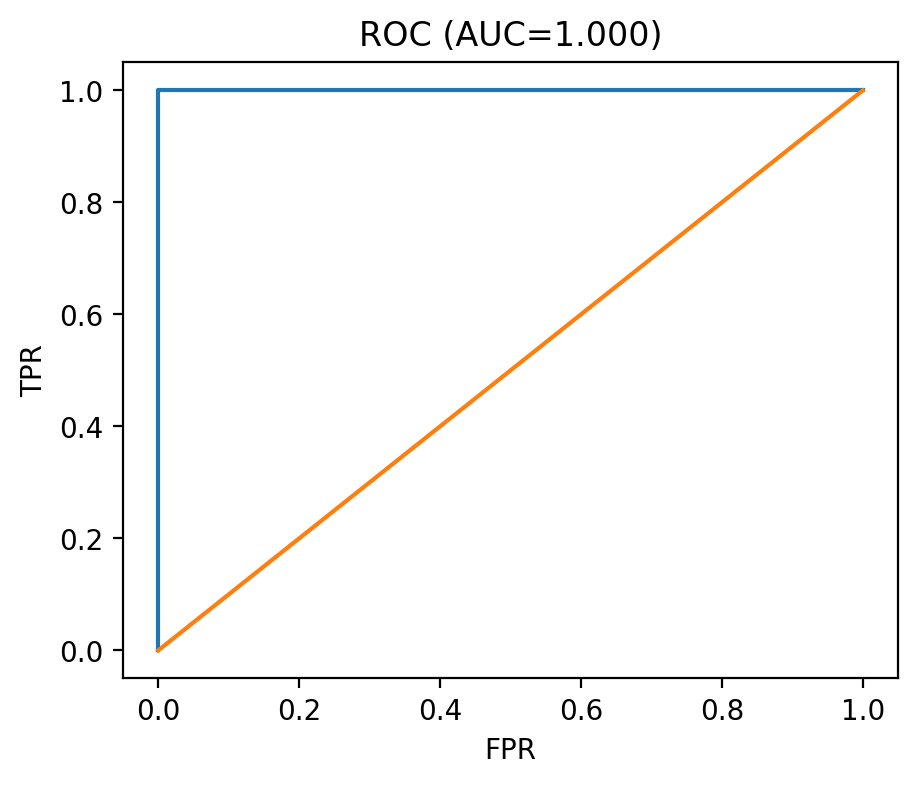

strength=0.80  AUC=1.000  P(real)= 0.0000


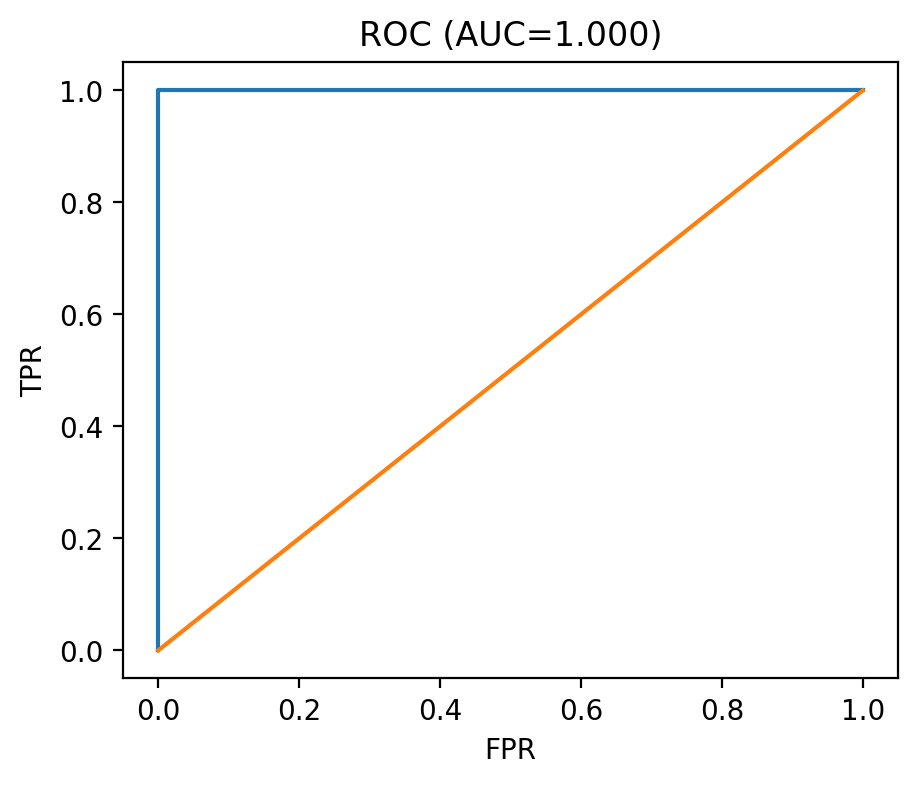

strength=0.90  AUC=1.000  P(real)= 1.0000


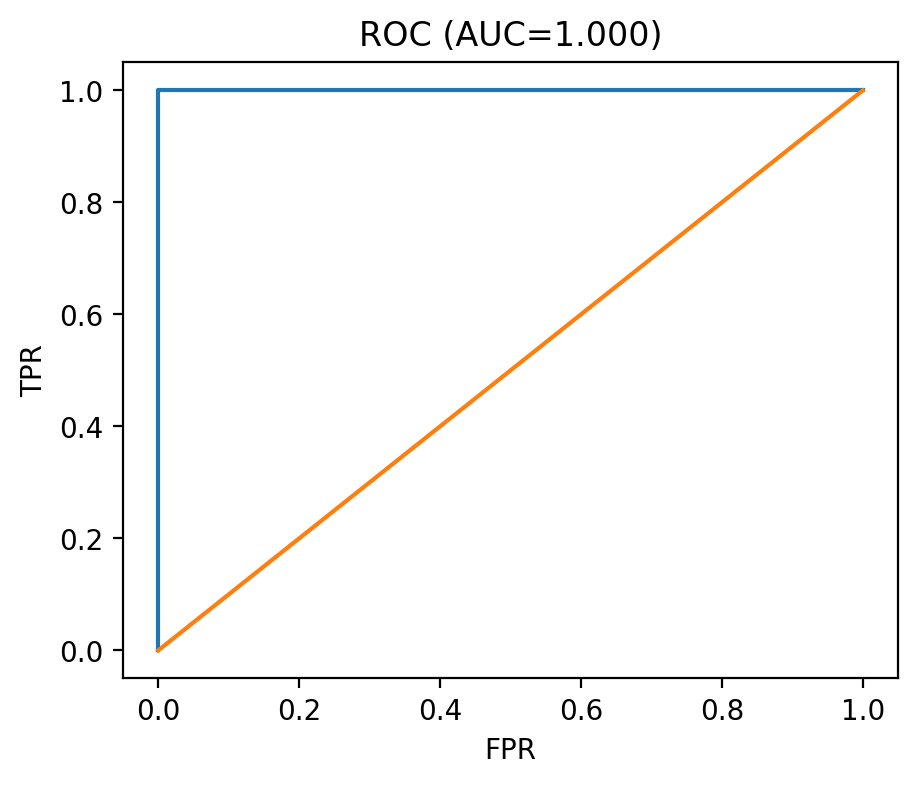

strength=1.00  AUC=1.000  P(real)= 0.0000


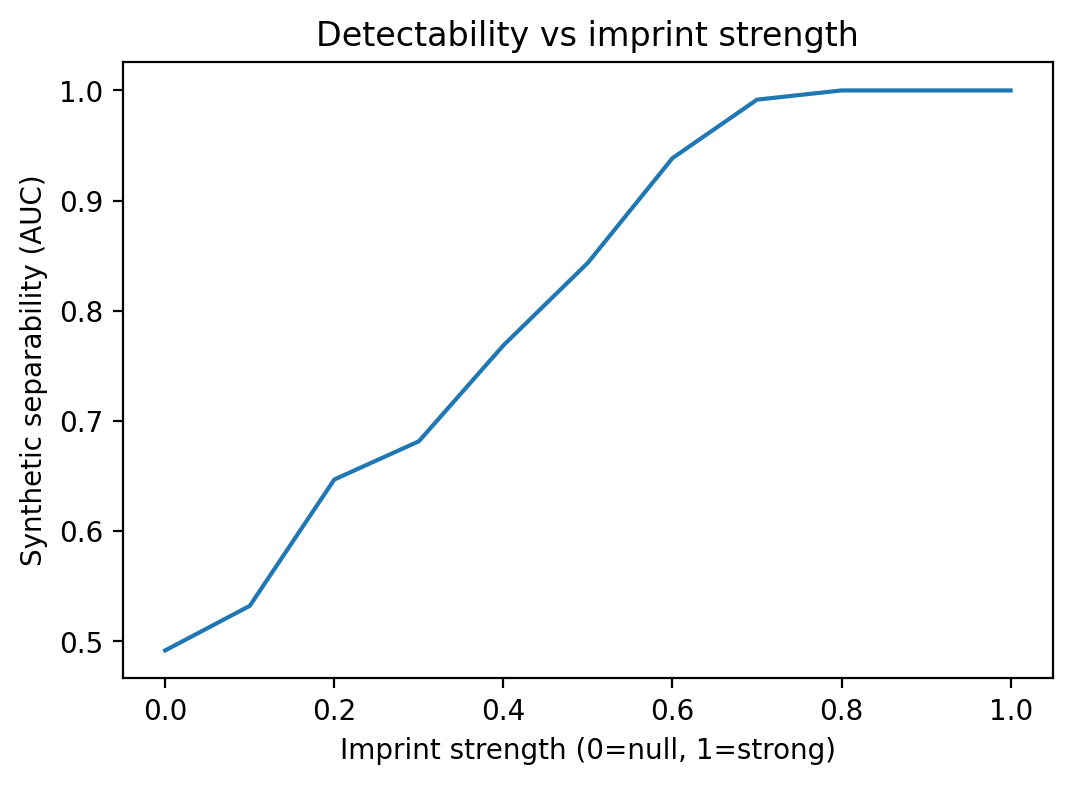

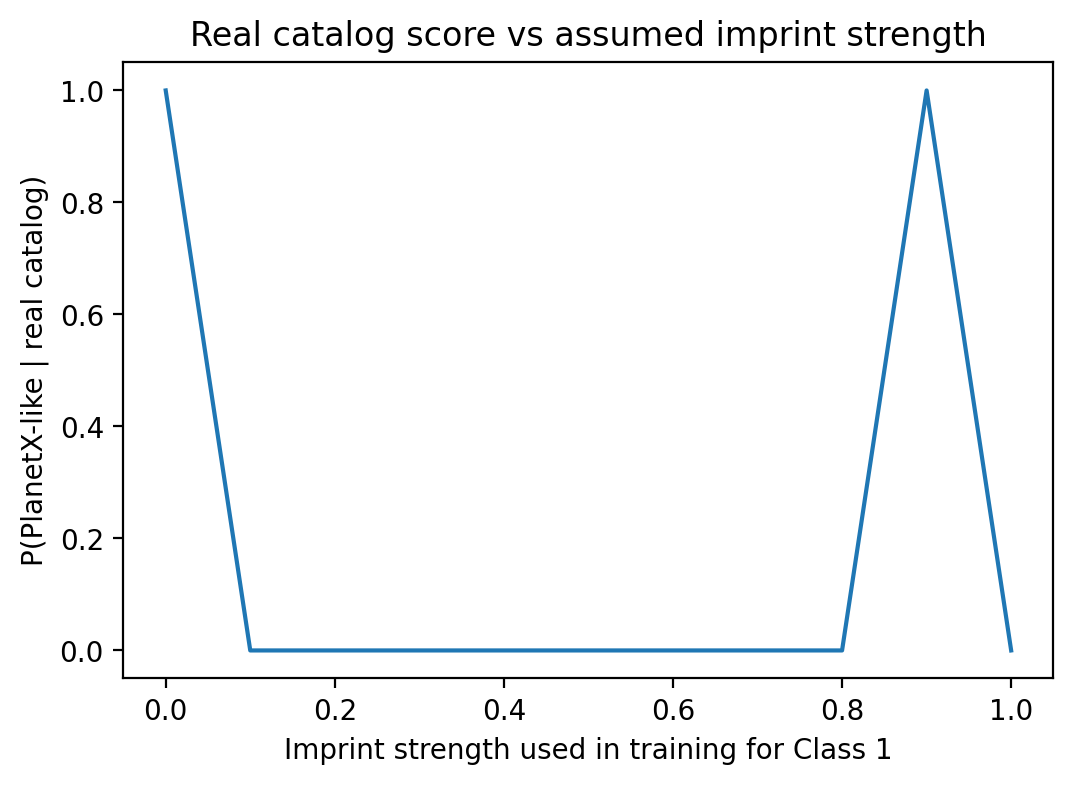

In [4]:
feat_real = catalog_features(aR, eR, incR, varpiR, OmegaR)

strength_grid = np.linspace(0, 1, 11)  
aucs = []
p_reals = []

for s in strength_grid:
    X, y = build_dataset(n_catalogs=2000, n_obs= len(aR), strength=float(s), seed=0)
    trained = train_and_eval(X, y, seed=0)
    aucs.append(trained["auc"])
    p_reals.append(predict_prob(trained, feat_real))
    print(f"strength={s:.2f}  AUC={trained['auc']:.3f}  P(real)= {p_reals[-1]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(strength_grid, aucs)
plt.xlabel("Imprint strength (0=null, 1=strong)")
plt.ylabel("Synthetic separability (AUC)")
plt.title("Detectability vs imprint strength")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(strength_grid, p_reals)
plt.xlabel("Imprint strength used in training for Class 1")
plt.ylabel("P(PlanetX-like | real catalog)")
plt.title("Real catalog score vs assumed imprint strength")
plt.show()


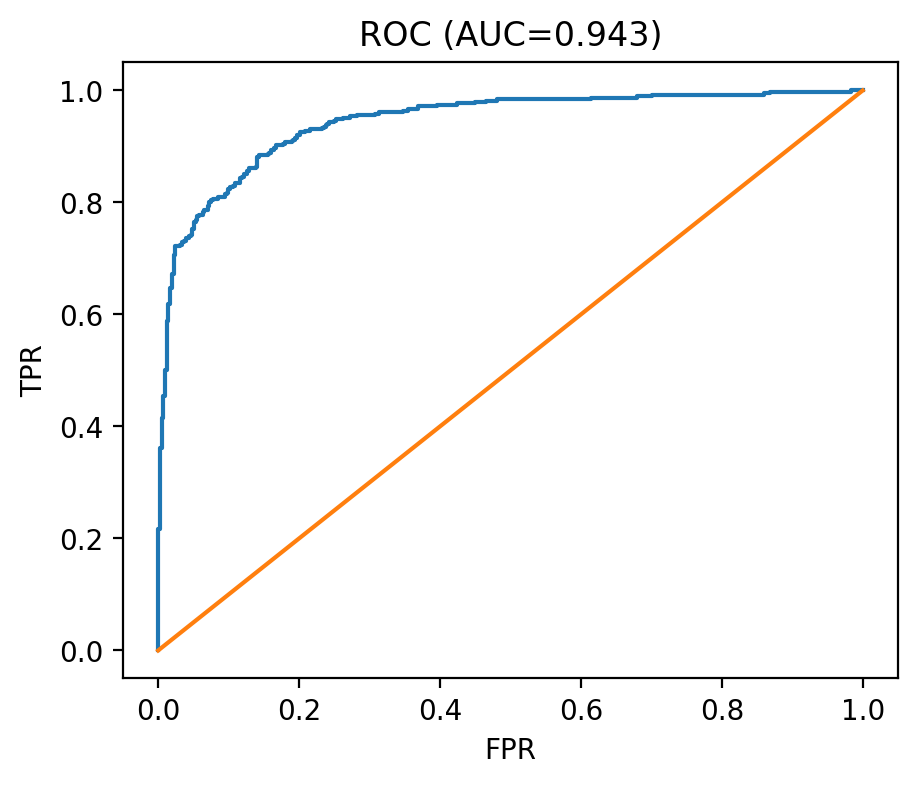

Bootstrap P(real) median: 0.0
Bootstrap P(real) 16-84%: 0.0 0.002690318954299243


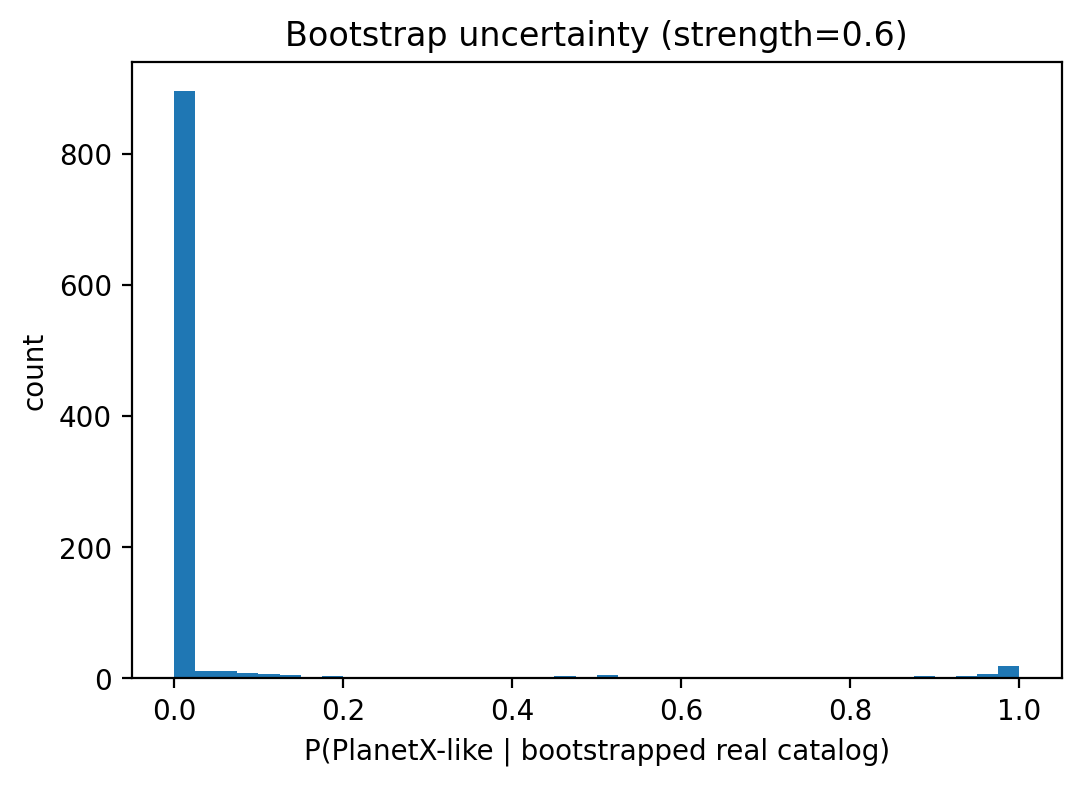

In [5]:
def bootstrap_real_probs(trained, aR, eR, incR, varpiR, OmegaR, B=1000, seed=0):
    np.random.seed(seed)
    n = len(aR)
    probs = []
    for _ in range(B):
        idx = np.random.randint(0, n, size=n)  
        feat = catalog_features(aR[idx], eR[idx], incR[idx], varpiR[idx], OmegaR[idx])
        probs.append(predict_prob(trained, feat))
    probs = np.array(probs, float)
    return probs

s = 0.6
X, y = build_dataset(n_catalogs=4000, n_obs=len(aR), strength=s, seed=1)
trained = train_and_eval(X, y, seed=1)

probs = bootstrap_real_probs(trained, aR, eR, incR, varpiR, OmegaR, B=1000, seed=2)

print("Bootstrap P(real) median:", float(np.median(probs)))
print("Bootstrap P(real) 16-84%:", float(np.quantile(probs, 0.16)), float(np.quantile(probs, 0.84)))

plt.figure(figsize=(6,4))
plt.hist(probs, bins=40)
plt.xlabel("P(PlanetX-like, bootstrapped real catalog)")
plt.ylabel("count")
plt.title(f"Bootstrap uncertainty (strength={s})")
plt.show()


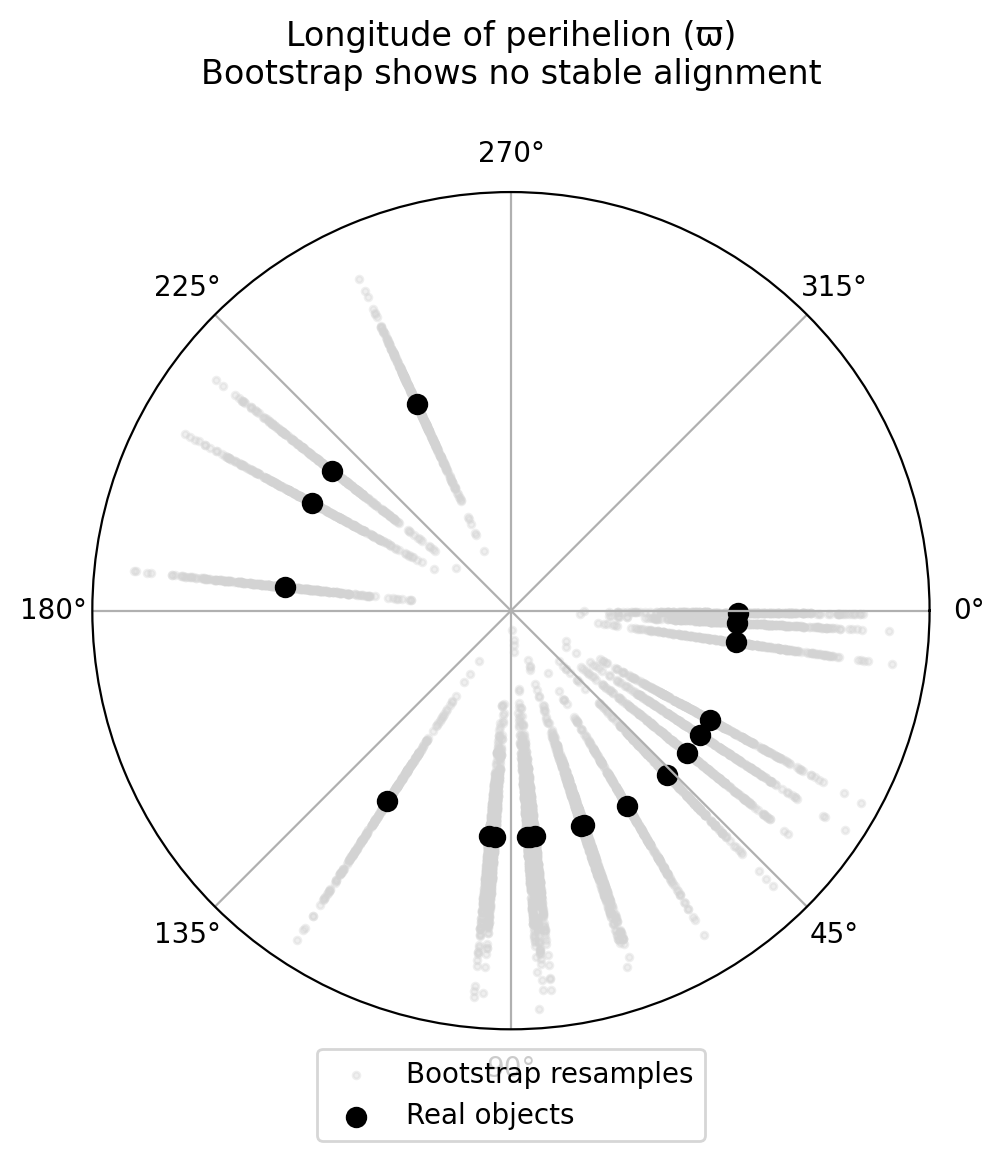

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_varpi_circle(varpiR, B=300, seed=0):
    np.random.seed(seed)
    n = len(varpiR)

    # bootstrap varpi clouds
    clouds = []
    for _ in range(B):
        idx = np.random.randint(0, n, size=n)
        clouds.append(varpiR[idx])
    clouds = np.concatenate(clouds)

    # convert to radians
    th_real = np.deg2rad(varpiR)
    th_cloud = np.deg2rad(clouds)

    # radial jitter purely for visibility
    r_real = np.ones_like(th_real)
    r_cloud = 1 + 0.12*np.random.randn(len(th_cloud))

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    ax.scatter(th_cloud, r_cloud, s=6, c="lightgrey", alpha=0.35, label="Bootstrap resamples")
    ax.scatter(th_real, r_real, s=45, c="black", label="Real objects")

    ax.set_rticks([])
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    ax.set_title("Longitude of perihelion (ϖ)\nBootstrap shows no stable alignment", pad=20)

    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    plt.show()

# call it
plot_varpi_circle(varpiR, B=300)



In [7]:
import numpy as np

def ang_wrap_deg(x):
    return np.mod(x, 360.0)

def compute_varpi_deg(real):
    return ang_wrap_deg(real["Omega"] + real["omega"])



varpi_all = compute_varpi_deg(real)            
a = real["a"]; e = real["e"]; inc = real["inc"]; Omega = real["Omega"]
q = a*(1-e)

mask = (a > 150) & (q > 30)                      
aR = a[mask]; eR = e[mask]; incR = inc[mask]; OmegaR = Omega[mask]
varpiR = varpi_all[mask]                        
print("After cuts:", len(varpiR), "objects")



After cuts: 20 objects


Loaded rows: 1508
After cuts: 20
Circular concentration R(varpi): 0.49077761438558193


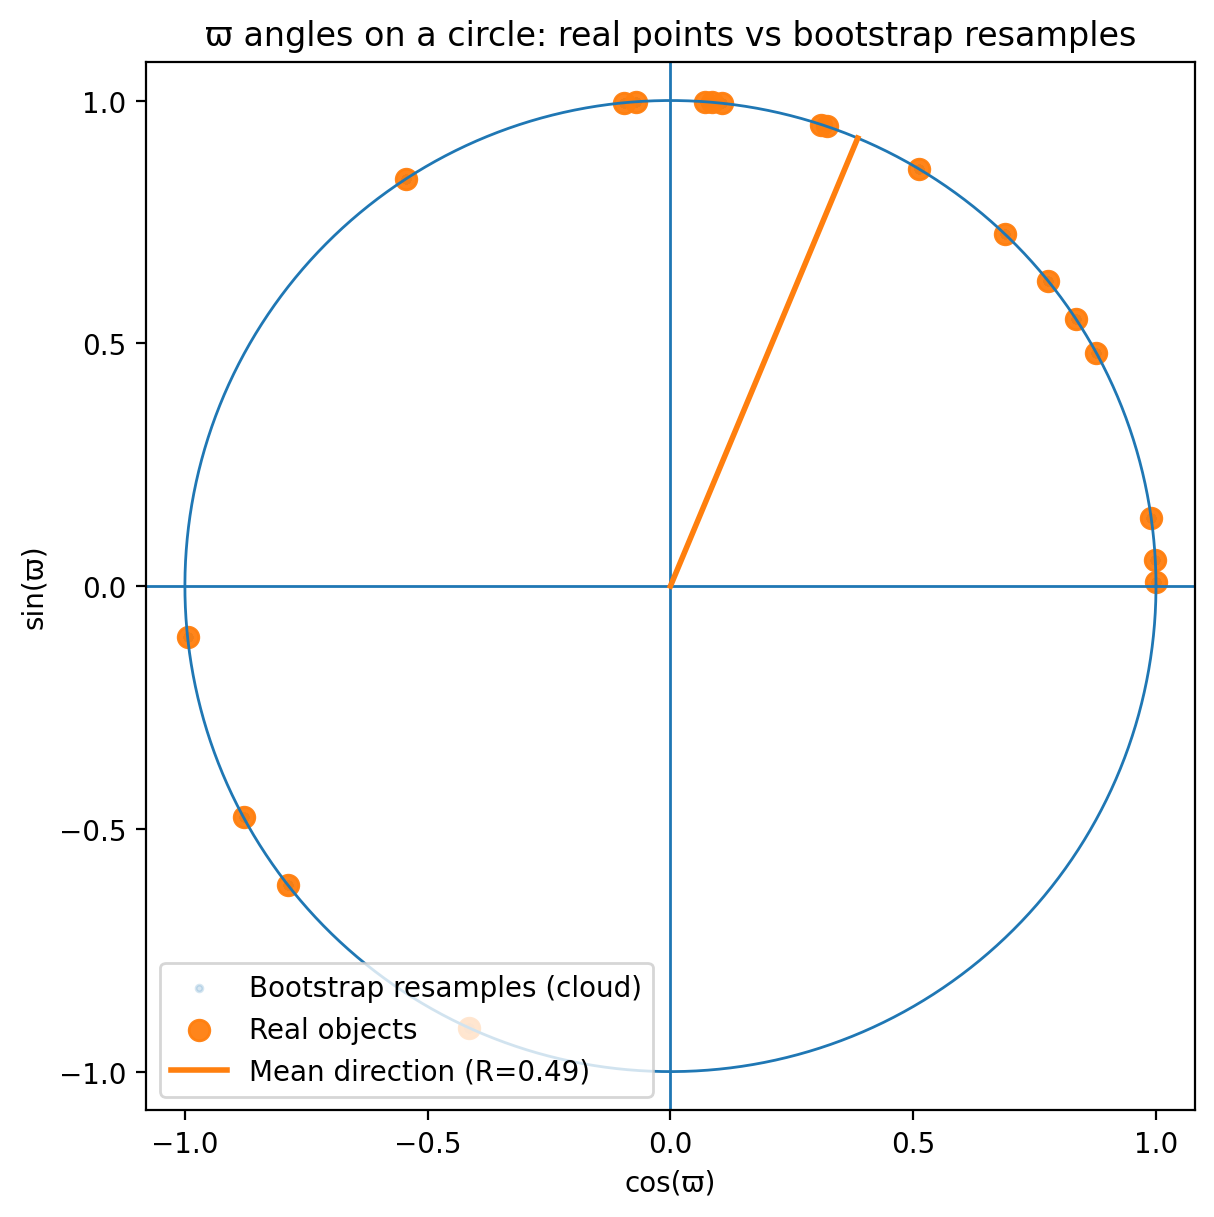

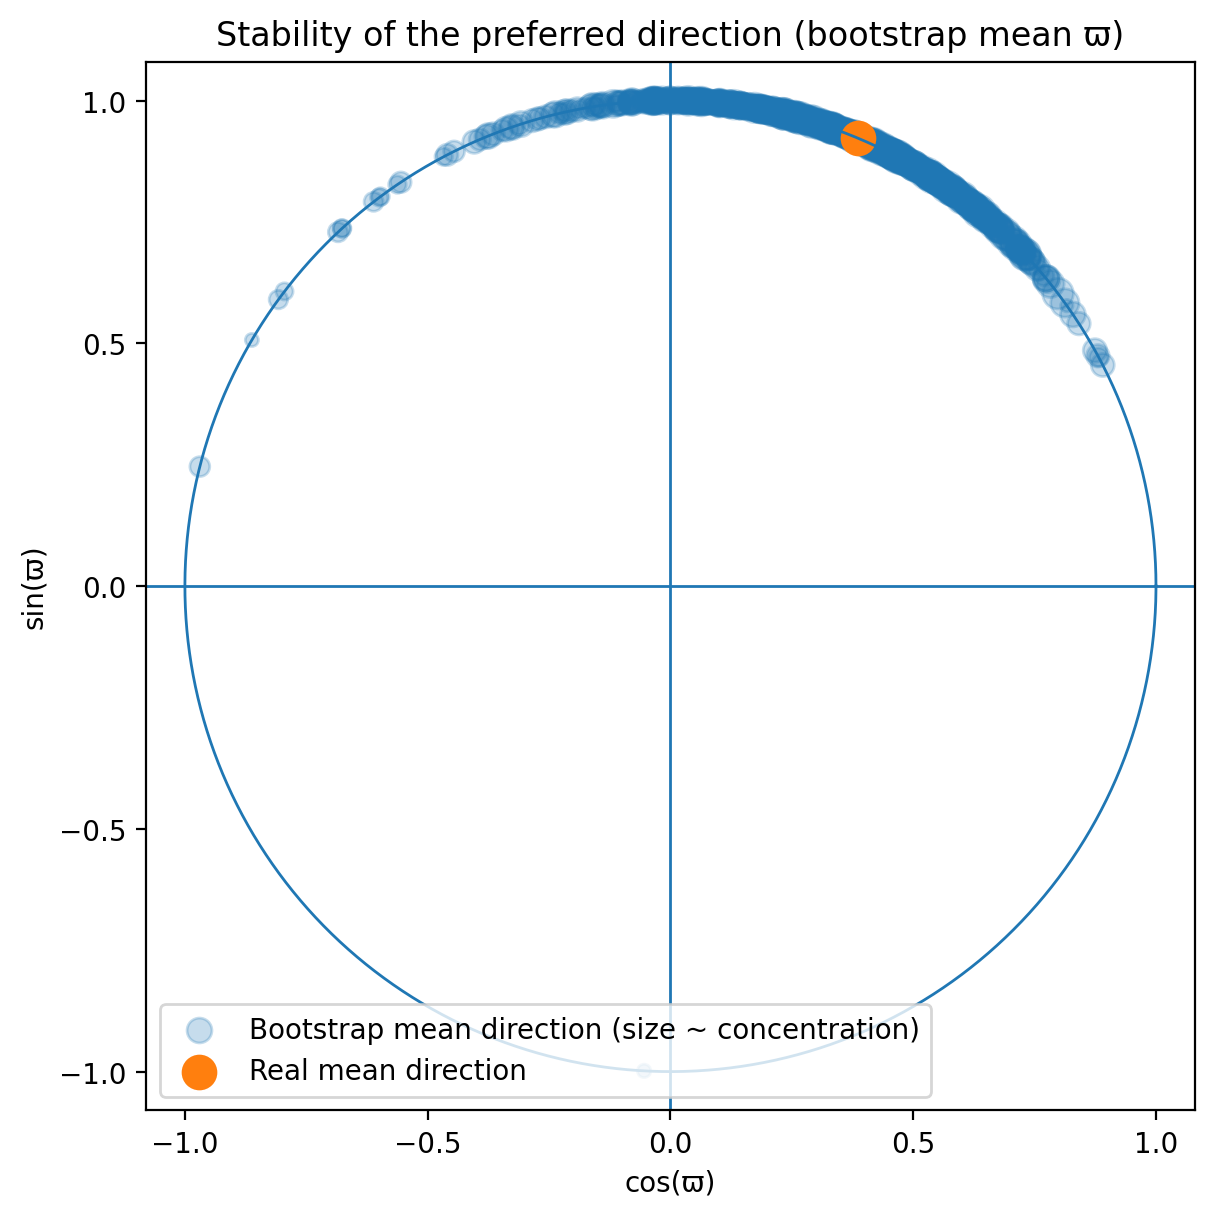

In [8]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

def _floats_from_line(line):
    nums = re.findall(r"[+-]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][+-]?\d+)?", line)
    return [float(x) for x in nums]

def load_mpc_distant(path, max_lines=None):
    """
    MPCORB-like: floats contain ... M, omega, Omega, inc, e, n, a ...
    Indices:          4    5      6     7   8      10
    """
    a=[]; e=[]; inc=[]; Om=[]; om=[]; M=[]
    raw = 0
    with open(path, "r", errors="ignore") as f:
        for line in f:
            raw += 1
            if max_lines is not None and raw > max_lines:
                break
            nums = _floats_from_line(line)
            if len(nums) < 11:
                continue
            MM  = nums[4]
            ww  = nums[5]
            OO  = nums[6]
            ii  = nums[7]
            ee  = nums[8]
            aa  = nums[10]
            if not (aa > 0 and 0 <= ee < 1.5 and 0 <= ii <= 180 and 0 <= OO <= 360 and 0 <= ww <= 360 and 0 <= MM <= 360):
                continue
            a.append(aa); e.append(ee); inc.append(ii); Om.append(OO); om.append(ww); M.append(MM)
    if len(a) == 0:
        raise ValueError(f"No valid rows parsed. PATH={path!r}. Try: print(os.getcwd()); print(os.listdir('.'))")
    return {
        "a": np.array(a, float),
        "e": np.array(e, float),
        "inc": np.array(inc, float),
        "Omega": np.array(Om, float),
        "omega": np.array(om, float),
        "M": np.array(M, float),
        "used_rows": len(a),
        "raw_lines": raw
    }

def ang_wrap_deg(x):
    return np.mod(x, 360.0)

def compute_varpi_deg(Omega, omega):
    return ang_wrap_deg(Omega + omega)

def circ_mean_deg(theta_deg):
    th = np.deg2rad(theta_deg)
    return ang_wrap_deg(np.rad2deg(np.arctan2(np.mean(np.sin(th)), np.mean(np.cos(th)))))

def circ_R(theta_deg):
    th = np.deg2rad(theta_deg)
    c = np.mean(np.cos(th))
    s = np.mean(np.sin(th))
    return float(np.sqrt(c*c + s*s))

def setup_unit_circle(ax, title):
    t = np.linspace(0, 2*np.pi, 800)
    ax.plot(np.cos(t), np.sin(t), linewidth=1)         
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-1.08, 1.08)
    ax.set_ylim(-1.08, 1.08)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlabel("cos(ϖ)")
    ax.set_ylabel("sin(ϖ)")
    ax.set_title(title)

def plot_varpi_points_and_bootstrap(varpi_deg, B=400, seed=0):
    np.random.seed(seed)
    varpi_deg = np.asarray(varpi_deg, float)
    n = len(varpi_deg)
    if n < 5:
        raise ValueError("Too few objects after cuts to make a meaningful plot.")

    th_real = np.deg2rad(varpi_deg)
    x_real = np.cos(th_real)
    y_real = np.sin(th_real)

    clouds = []
    for _ in range(B):
        idx = np.random.randint(0, n, size=n)
        clouds.append(varpi_deg[idx])
    clouds = np.concatenate(clouds)
    th_cloud = np.deg2rad(clouds)
    x_cloud = np.cos(th_cloud)
    y_cloud = np.sin(th_cloud)

    fig, ax = plt.subplots(figsize=(6.2, 6.2))
    setup_unit_circle(ax, "ϖ angles on a circle: real points vs bootstrap resamples")

    ax.scatter(x_cloud, y_cloud, s=6, alpha=0.18, label="Bootstrap resamples (cloud)")
    ax.scatter(x_real, y_real, s=55, alpha=0.95, label="Real objects")

    mu = circ_mean_deg(varpi_deg)
    th_mu = np.deg2rad(mu)
    ax.plot([0, np.cos(th_mu)], [0, np.sin(th_mu)], linewidth=2, label=f"Mean direction (R={circ_R(varpi_deg):.2f})")

    ax.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

def plot_bootstrap_mean_directions(varpi_deg, B=800, seed=1):
    np.random.seed(seed)
    varpi_deg = np.asarray(varpi_deg, float)
    n = len(varpi_deg)

    means = np.zeros(B, float)
    Rs = np.zeros(B, float)
    for b in range(B):
        idx = np.random.randint(0, n, size=n)
        sample = varpi_deg[idx]
        means[b] = circ_mean_deg(sample)
        Rs[b] = circ_R(sample)

    th = np.deg2rad(means)
    x = np.cos(th)
    y = np.sin(th)

    mu_real = circ_mean_deg(varpi_deg)
    th_mu = np.deg2rad(mu_real)

    fig, ax = plt.subplots(figsize=(6.2, 6.2))
    setup_unit_circle(ax, "Stability of the preferred direction (bootstrap mean ϖ)")

  
    sizes = 20 + 120*(Rs - Rs.min())/(Rs.max() - Rs.min() + 1e-12)
    ax.scatter(x, y, s=sizes, alpha=0.25, label="Bootstrap mean direction (size ~ concentration)")

    ax.scatter([np.cos(th_mu)], [np.sin(th_mu)], s=140, label="Real mean direction")

    ax.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

PATH = "distant_extended.dat"
if not os.path.exists(PATH):
    print("File not found:", PATH)
    print("cwd:", os.getcwd())
    print("files:", os.listdir("."))
    raise FileNotFoundError(PATH)

real = load_mpc_distant(PATH)
print("Loaded rows:", real["used_rows"])

a = real["a"]; e = real["e"]; inc = real["inc"]
Omega = real["Omega"]; omega = real["omega"]

varpi = compute_varpi_deg(Omega, omega)
q = a*(1-e)

mask = (a > 150) & (q > 30)

aR = a[mask]; eR = e[mask]; incR = inc[mask]
OmegaR = Omega[mask]; omegaR = omega[mask]
varpiR = varpi[mask]

print("After cuts:", len(varpiR))
print("Circular concentration R(varpi):", circ_R(varpiR))

plot_varpi_points_and_bootstrap(varpiR, B=400, seed=0)
plot_bootstrap_mean_directions(varpiR, B=800, seed=1)


In [11]:
def mc_p_value_R(varpi_deg, M=50000, seed=0):
    np.random.seed(seed)
    n = len(varpi_deg)
    R_real = circ_R(varpi_deg)
    th = np.random.uniform(0, 2*np.pi, size=(M, n))
    c = np.mean(np.cos(th), axis=1)
    s = np.mean(np.sin(th), axis=1)
    R_sim = np.sqrt(c*c + s*s)
    p = float(np.mean(R_sim >= R_real))
    return R_real, p

R_real, p = mc_p_value_R(varpiR)
print("R_real =", R_real)
print("MC p-value =", p)


R_real = 0.49077761438558193
MC p-value = 0.00614


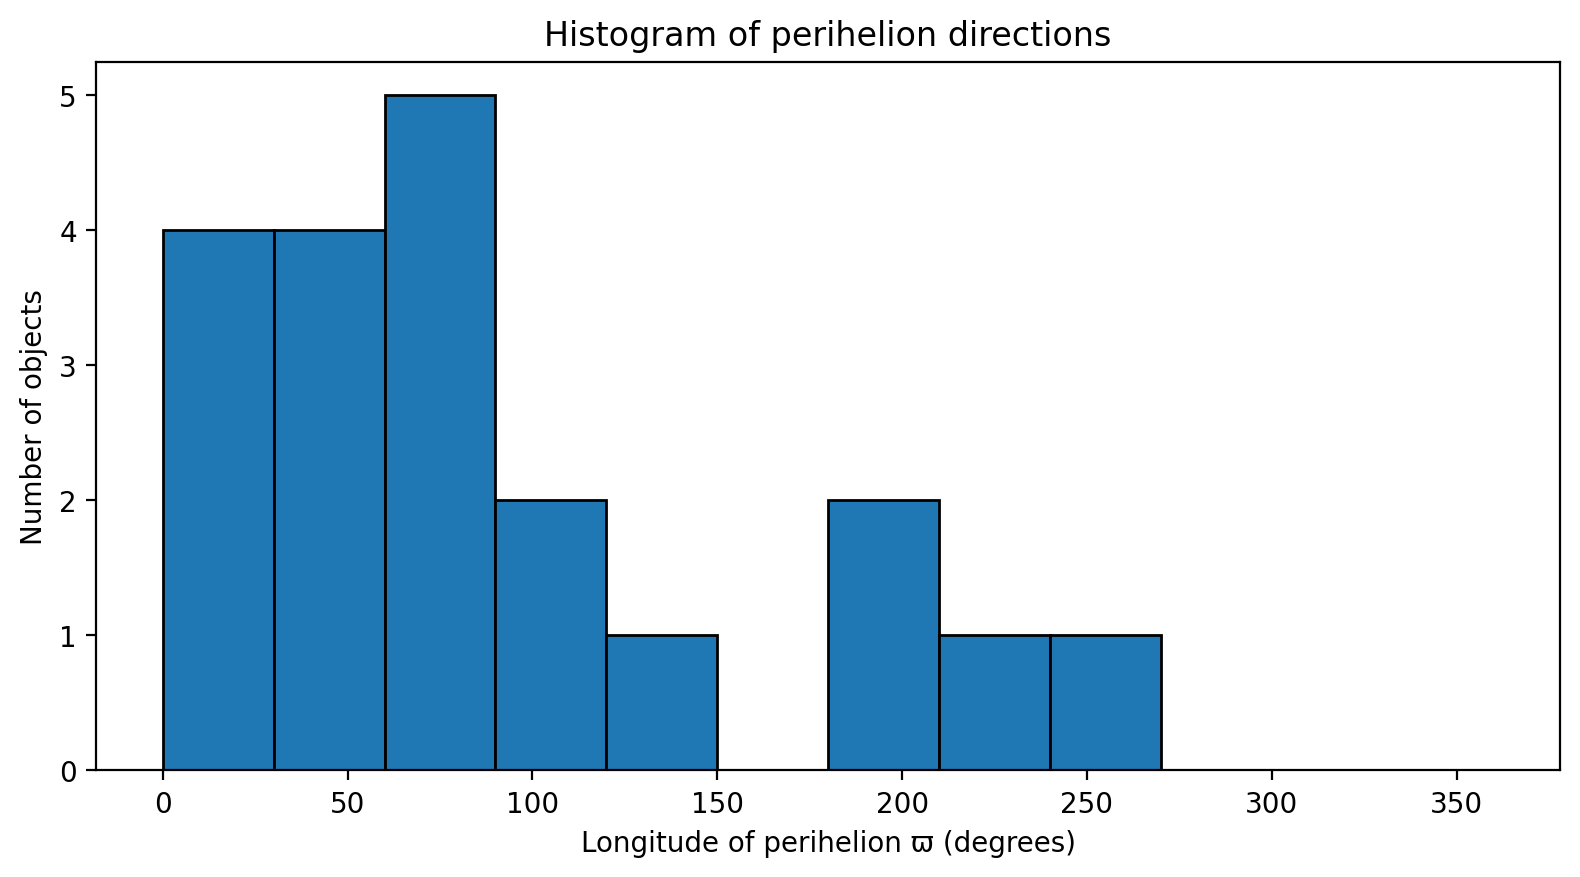

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.5))
plt.hist(varpiR, bins=12, range=(0,360), edgecolor="black")
plt.xlabel("Longitude of perihelion ϖ (degrees)")
plt.ylabel("Number of objects")
plt.title("Histogram of perihelion directions")
plt.tight_layout()
plt.show()


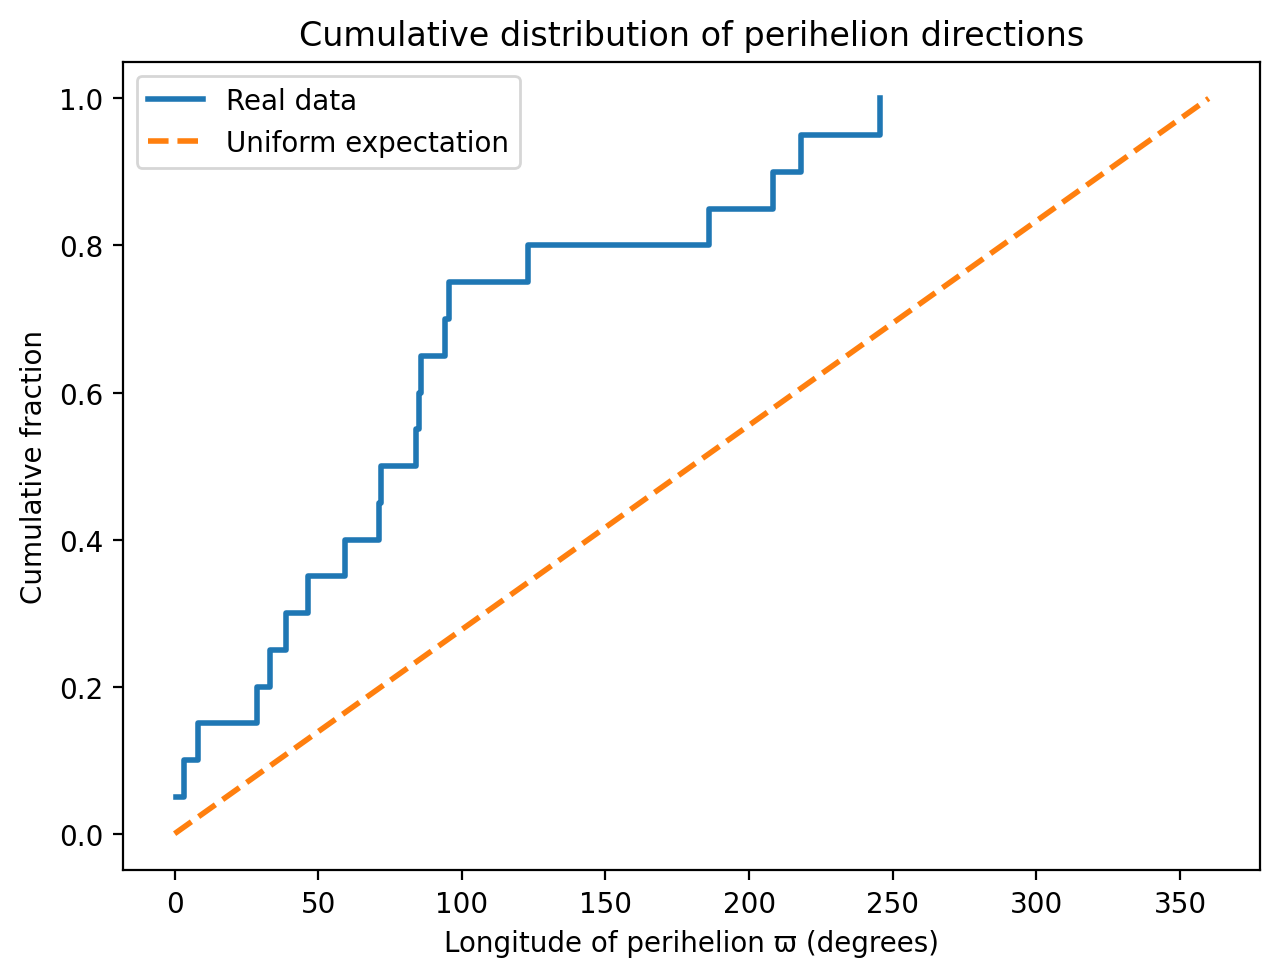

In [10]:
v_sorted = np.sort(varpiR)
n = len(v_sorted)

cdf_emp = np.arange(1, n+1) / n

x_uniform = np.linspace(0, 360, 1000)
cdf_uniform = x_uniform / 360.0

plt.figure(figsize=(6.5,5))
plt.plot(v_sorted, cdf_emp, drawstyle="steps-post", linewidth=2, label="Real data")
plt.plot(x_uniform, cdf_uniform, linestyle="--", linewidth=2, label="Uniform expectation")
plt.xlabel("Longitude of perihelion ϖ (degrees)")
plt.ylabel("Cumulative fraction")
plt.title("Cumulative distribution of perihelion directions")
plt.legend()
plt.tight_layout()
plt.show()
